An interesting feature of deep learning models is that once it's been trained on some general task, it is possible to channel its predictive power for more specific tasks, this is called Transfer Learning.

The principle is simple, instead of building a neural network architecture from scratch, we will use pre-made and pre-trained architectures. This technique allows us to achieve state of the art performance results.

This course therefore aims to show how to perform Transfer Learning with Tensorflow. We will use this for image recognition on flower types contained in a flower_photos folder.

# Loading dataset & preprocessing.

Downloading images from paths

In [40]:
import tensorflow as tf

We will use the get_file method of the tf.keras.utils module to download public data contained in Google Cloud Storage that we will then store in a flower_photos folder.

In [41]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='/content/flower_photos.tgz',
                                         untar=True,
                                         cache_subdir="/content")
data_root = pathlib.Path("/content/flower_photos")
print(data_root)

/content/flower_photos


In the code above, we specify the following parameters:

origin: the url to which the data is contained
fname: is the name of the file you wish to download. You can also specify the path where the file should be stored.
untar: This allows you to unpack files automatically.
cache_subdir: This specifies the subfolder where the decompressed data should be stored.
Now let's take a look at the folder's content.

In [42]:
for item in data_root.iterdir():
  print(item)

/content/flower_photos/LICENSE.txt
/content/flower_photos/dandelion
/content/flower_photos/sunflowers
/content/flower_photos/roses
/content/flower_photos/tulips
/content/flower_photos/daisy


We will now create an ImageDataGenerator object in order to use data augmentation on our flower images.

In [43]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(#rotation_range=90,
                                                                brightness_range=(0.5,1),
                                                                #shear_range=0.2,
                                                                #zoom_range=0.2,
                                                                channel_shift_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rescale=1./255,
                                                                validation_split=0.3)

Now that we have set up the transformations we wish to apply to our images on the fly, we will create two objects that will be able to produce images on demand from the train set and valdiation set respectively.

We are able to set up the target image size and the batch size during this step too!

In [44]:
img_generator_flow_train = img_generator.flow_from_directory(
    directory="/content/flower_photos",
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="training")

img_generator_flow_valid = img_generator.flow_from_directory(
    directory="/content/flower_photos",
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="validation")

Found 2572 images belonging to 5 classes.
Found 1098 images belonging to 5 classes.


Let's visualize a batch of images from the train set.

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

imgs, labels = next(iter(img_generator_flow_train))
for img, label in zip(imgs, labels):
  true_file_path = np.argmax(img_generator_flow_train.labels == tf.argmax(label))
  true_label_name = Path(img_generator_flow_train.filepaths[true_file_path]).parent.name
  print("Label :", true_label_name)
  plt.imshow(img)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

We are now all set, and ready to embark on our transfer learning journey!

# Transfer Learning

**Importing a pre-trained model**

Now that our images are pre-processed, we can move on to the modeling part. We will use an already existing architecture: MobileNet and use it to classify our flowers. Here is how we can proceed:

In [46]:
base_model = tf.keras.applications.MobileNet(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

Here we have imported the architecture to which we have specified not to take the last output layer. Indeed, this layer will be adapted to our need for flower classification. This model has been trained on a much larger number of different images from the imagenet dataset.

Let's have a quick look at the architecture of our model:

In [47]:
base_model.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

Now we have to freeze our model so that only the custom layers will train.

In [48]:
base_model.trainable = False

This prevents us from training our entire model. Let us now add the last layer which interests us for our problem

# Adapting the model to the dataset

When we imported our model, we removed the last layer to be able to adapt the model to our situation. So now let's use the next cell of code to add our last layer.

We will use a GlobalMaxPooling2D layer which will output the most significant pixels of the image, and a last Dense layer which will take the number of classes of our dataset and a softmax activation function which will output probabilities for each of the predictions.

In [49]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(set(img_generator_flow_train.labels)), activation="softmax")
])

Let's prepare our cost function, our optimization and a learning rate schedule to improve our prediction results and minimize our cost function.

In [50]:
# Let's create a learning rate schedule to decrease the learning rate as we train the model.
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

In [51]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [52]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_3               │ (None, 1024)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,233,989 (12.34 MB)

 Trainable params: 5,125 (20.02 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

Now let's practice our model.

In [53]:
model.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, epochs=5)

Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 27s 287ms/step - categorical_accuracy: 0.4184 - loss: 2.8304 - val_categorical_accuracy: 0.6867 - val_loss: 1.2585
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 40s 288ms/step - categorical_accuracy: 0.7538 - loss: 0.9146 - val_categorical_accuracy: 0.7131 - val_loss: 1.1903
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 240ms/step - categorical_accuracy: 0.7989 - loss: 0.7443 - val_categorical_accuracy: 0.7778 - val_loss: 0.8513
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 225ms/step - categorical_accuracy: 0.8458 - loss: 0.5188 - val_categorical_accuracy: 0.7914 - val_loss: 0.7637
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 235ms/step - categorical_accuracy: 0.8457 - loss: 0.5336 - val_categorical_accuracy: 0.7550 - val_loss: 1.0732


Our results are not bad already! We can however try to continue training our model but this time by releasing some layers. This is called fine tuning. So we're going to unlock the last 20 layers of the model.

In [54]:
base_model = tf.keras.applications.MobileNet(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

In [55]:
len(base_model.layers)

86

In [56]:
base_model.trainable = True

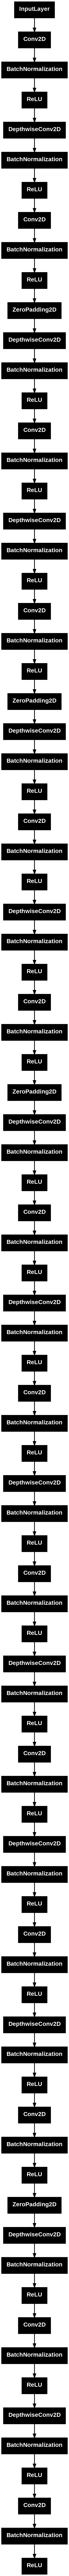

In [57]:
tf.keras.utils.plot_model(base_model)

In [58]:
fine_tune_at = len(base_model.layers) - 10
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [59]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(set(img_generator_flow_train.labels)), activation="softmax")
])

In [60]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_4               │ (None, 1024)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,233,989 (12.34 MB)

 Trainable params: 1,593,349 (6.08 MB)

 Non-trainable params: 1,640,640 (6.26 MB)

Let's try to train the model again.

In [61]:
# You will need to run a new model.compile before re-training the model.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])


model.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, epochs=5)

Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 285ms/step - categorical_accuracy: 0.6915 - loss: 2.5970 - val_categorical_accuracy: 0.6831 - val_loss: 1.3531
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 241ms/step - categorical_accuracy: 0.9027 - loss: 0.4479 - val_categorical_accuracy: 0.7077 - val_loss: 1.4397
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 227ms/step - categorical_accuracy: 0.9324 - loss: 0.2340 - val_categorical_accuracy: 0.6594 - val_loss: 2.3609
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - categorical_accuracy: 0.9510 - loss: 0.2150 - val_categorical_accuracy: 0.7796 - val_loss: 1.2553
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 24s 290ms/step - categorical_accuracy: 0.9523 - loss: 0.1847 - val_categorical_accuracy: 0.7058 - val_loss: 2.2388


# Visualize the learning process

To visualize the learning process, you will use the history attribute from your model object.

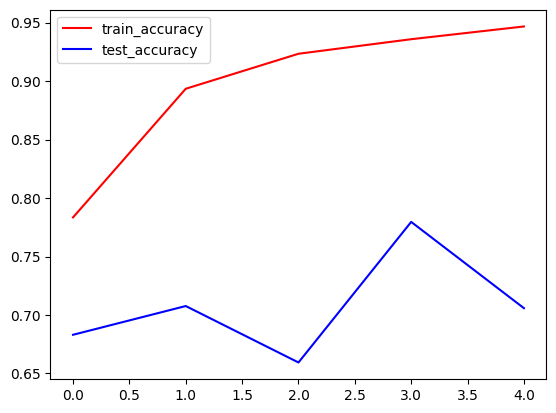

In [62]:
# Visualise train / Valid Accuracy
plt.plot(model.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

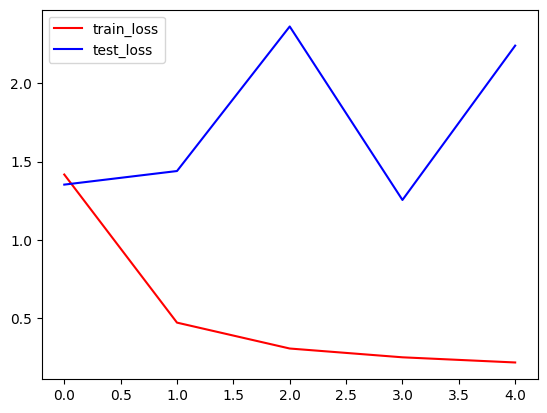

In [63]:
# Visualise train / Valid Loss
plt.plot(model.history.history["loss"], c="r", label="train_loss")
plt.plot(model.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()